# 05. Transfer Learning with TensorFlow Part 2: Fine-tuning

In [ ]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.12.0


In [ ]:
# Check if we are connected to GPU
!nvidia-smi

Wed Jun 28 03:23:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper function

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-28 03:23:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-28 03:23:26 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
#Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

We will look at pre-trained models in tf.keras.application

In [ ]:
## data
! wget 'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip'


--2023-06-28 03:23:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  24.0MB/s    in 8.1s    

2023-06-28 03:23:36 (19.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
unzip_data('10_food_classes_10_percent.zip')

In [ ]:
# import zipfile
# local = '10_food_classes_10_percent.zip'
# zipref = zipfile.ZipFile(local)
# zipref.extractall()
# zipref.close()

In [ ]:
walk_through_dir('/content/10_food_classes_10_percent')

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent

In [ ]:
# Create directories
train_dir = '/content/10_food_classes_10_percent/train'
test_dir = '/content/10_food_classes_10_percent/test'

In [ ]:
import tensorflow as tf

In [ ]:
IMAGE_SIZE=(224,224)
BATCH_SIZE = 32


train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    label_mode='categorical',
                                                                    image_size=IMAGE_SIZE,
                                                                    batch_size=BATCH_SIZE)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                    label_mode='categorical',
                                                                    image_size=IMAGE_SIZE,
                                                                    batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
for images,labels in  train_dataset.take(1):
    print(images[0], labels[0])


tf.Tensor(
[[[ 17.701849    12.70185      8.70185   ]
  [ 16.547512    11.547513     7.5475125 ]
  [ 14.72736      9.72736      5.72736   ]
  ...
  [ 34.883877    29.338614    23.338614  ]
  [ 33.357143    28.357143    22.357143  ]
  [ 32.89924     29.89924     22.89924   ]]

 [[ 20.34088     15.340879    11.340879  ]
  [ 18.911036    13.911034     9.911034  ]
  [ 21.966839    16.966839    12.966838  ]
  ...
  [ 35.235573    30.675035    26.455305  ]
  [ 32.865433    29.857143    24.861288  ]
  [ 34.504482    31.504482    24.504482  ]]

 [[ 20.857143    15.857143    11.857143  ]
  [ 22.56537     17.56537     13.565371  ]
  [ 25.985332    20.985332    16.985332  ]
  ...
  [ 37.112873    32.53543     28.400211  ]
  [ 37.525845    34.31156     29.740131  ]
  [ 38.062805    34.84852     30.27709   ]]

 ...

 [[  0.55450755   6.183535     4.3349504 ]
  [ 11.930092    21.306877    20.735405  ]
  [ 96.782364   109.00264    109.35812   ]
  ...
  [137.2737     163.1668     176.68582   ]
  [127.

In [ ]:
train_dataset.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
effNet_instance = tf.keras.applications.EfficientNetB0(
                      include_top=False,
                      weights='imagenet')


16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
IMAGE_SIZE+(3,)

(224, 224, 3)

In [ ]:
# TF Sequential API format

model = tf.keras.Sequential([
          tf.keras.layers.Input(shape=(IMAGE_SIZE+(3,))),
          tf.keras.applications.EfficientNetB0(include_top=False),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(10, activation='softmax')
    ])

model.layers[0].trainable=False
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(train_dataset, epochs=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 10)                627210    
                                                                 
Total params: 4,676,781
Trainable params: 627,210
Non-trainable params: 4,049,571
_________________________________________________________________
24/24 [==============================] - 16s 66ms/step - loss: 2.4234 - accuracy: 0.5733


In [ ]:
model.evaluate(test_dataset)

79/79 [==============================] - 10s 88ms/step - loss: 1.2279 - accuracy: 0.7764


[1.227863073348999, 0.7764000296592712]

In [ ]:
len(train_dataset)

24

## We will be using Functional API

In [ ]:
# Model:0 using functional API

# Create the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the basemodel
base_model.trainable = False

# Create Input layer
inputs = tf.keras.layers.Input(shape=(224,224, 3), name='input_layer')

# If using ResNet50V2 you will need to normalize inputs
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)

# Pass th einput through base_model
x = base_model(inputs)
print(x.shape)

# Average pooling
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
print(x.shape)

# Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)
print(x.shape)

# Combine the inputs and outputs in Model
model_0 = tf.keras.Model(inputs, outputs)


(None, 7, 7, 1280)
(None, 1280)
(None, 1280)


In [ ]:
#compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# callbacks
tensorboard_callback = create_tensorboard_callback('transfer_learning', experiment_name='EffNetB0_feature_extraction')

# Fit the model and save history
history_0 = model_0.fit(train_dataset,
                        epochs=5,
                        steps_per_epoch=len(train_dataset),
                        validation_data=test_dataset,
                        validation_steps=(0.25*len(test_dataset)),
                        callbacks=[tensorboard_callback])

Saving TensorBoard log files to: transfer_learning/EffNetB0_feature_extraction/20230628-032422
Epoch 1/5
24/24 [==============================] - 13s 250ms/step - loss: 1.8947 - accuracy: 0.4480 - val_loss: 1.3097 - val_accuracy: 0.7250
Epoch 2/5
24/24 [==============================] - 4s 139ms/step - loss: 1.0981 - accuracy: 0.7467 - val_loss: 0.8795 - val_accuracy: 0.7937
Epoch 3/5
24/24 [==============================] - 7s 294ms/step - loss: 0.7939 - accuracy: 0.8240 - val_loss: 0.7085 - val_accuracy: 0.8250
Epoch 4/5
24/24 [==============================] - 5s 176ms/step - loss: 0.6434 - accuracy: 0.8533 - val_loss: 0.5991 - val_accuracy: 0.8422
Epoch 5/5
24/24 [==============================] - 7s 290ms/step - loss: 0.5440 - accuracy: 0.8800 - val_loss: 0.5579 - val_accuracy: 0.8531


In [ ]:
results_model_0_feature_extraction = model_0.evaluate(test_dataset)
results_model_0_feature_extraction

79/79 [==============================] - 7s 85ms/step - loss: 0.5577 - accuracy: 0.8640


[0.5576697587966919, 0.8640000224113464]

In [ ]:
for layer_no, layer in enumerate(model_0.layers):
    print(f"{layer_no}. {layer}, {layer.trainable}")

0. <keras.engine.input_layer.InputLayer object at 0x7f202af1f880>, True
1. <keras.engine.functional.Functional object at 0x7f202a0fc820>, False
2. <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f2024e956c0>, True
3. <keras.layers.core.dense.Dense object at 0x7f2024f13550>, True


In [ ]:
for layer_no, layer in enumerate(base_model.layers):
    print(f"{layer_no}. {layer}, {layer.trainable}")
# note the second layer - keras.layers.preprocessing.image_preprocessing.Rescaling,
# hence we didn't require to rescale

0. <keras.engine.input_layer.InputLayer object at 0x7f202ab8df00>, False
1. <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f202ab8faf0>, False
2. <keras.layers.preprocessing.normalization.Normalization object at 0x7f202ab8ea10>, False
3. <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f202b6fdd50>, False
4. <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f202af1d4b0>, False
5. <keras.layers.convolutional.conv2d.Conv2D object at 0x7f20b01eff40>, False
6. <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f20b0128dc0>, False
7. <keras.layers.core.activation.Activation object at 0x7f202aba2860>, False
8. <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f202aba07c0>, False
9. <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f20b00e5990>, False
10. <keras.layers.core.activation.Activation object at 0x7f202aba3070>, False
11. <keras.layers.pool

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_4 (Rescaling)        (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_4[0][0]']            
 )                              3)                                                   

## Feature vector from our base model

In [ ]:
## Feature vector from our base model
base_model.layers[-1].output

<KerasTensor: shape=(None, None, None, 1280) dtype=float32 (created by layer 'top_activation')>

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


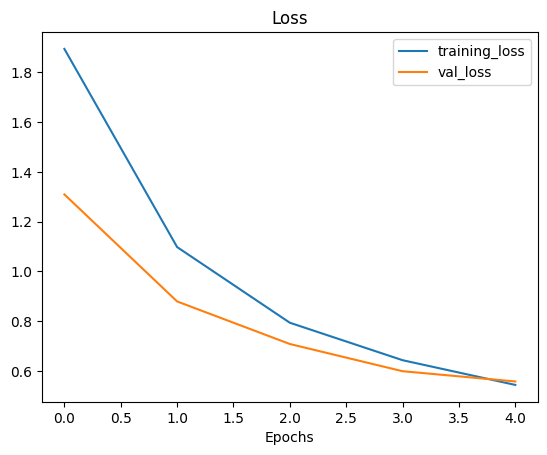

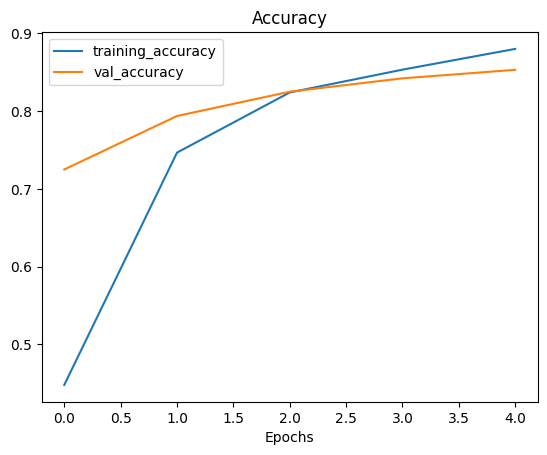

In [ ]:
plot_loss_curves(history_0)

In [ ]:
## how to get a feature vector from trained model
## lets demostarte global average pooling
tf.random.set_seed=42

input_shape=(1,4,4,3)
tensor = tf.random.normal(input_shape)
print(tensor.shape)

(1, 4, 4, 3)


In [ ]:
tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[ 1.0904214 ,  0.6304412 ,  0.4182575 ],
         [ 0.30271894,  0.23998412, -1.7664511 ],
         [ 0.43040523,  0.4710687 ,  1.1169604 ],
         [-0.9982315 ,  1.9410213 ,  1.2065502 ]],

        [[-0.7440008 , -1.0241692 , -1.4059197 ],
         [-1.0690204 , -0.6058046 ,  1.7535161 ],
         [-2.1542888 , -0.5293538 , -0.3011872 ],
         [-0.05361252,  1.0303253 ,  1.3639615 ]],

        [[ 1.2703863 , -1.7628319 , -1.3472073 ],
         [-0.53184336, -0.8647302 , -0.46693793],
         [ 0.44560748,  1.7813478 , -0.28771308],
         [ 0.79068756,  1.3899055 , -0.34941357]],

        [[-0.47252545, -0.35056606, -1.7966441 ],
         [ 0.73803246,  0.96207476,  0.14488064],
         [ 0.09157687,  0.7330384 ,  0.6075449 ],
         [ 0.32027212,  0.85193825,  1.7399461 ]]]], dtype=float32)>

In [ ]:
global_avg_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(tensor)
global_avg_pooled_tensor.shape

TensorShape([1, 3])

In [ ]:
global_avg_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.0339634 ,  0.3058556 ,  0.03938397]], dtype=float32)>

In [ ]:
# Lets replicate global average pooling
tf.reduce_mean(tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.0339634 ,  0.3058556 ,  0.03938397]], dtype=float32)>

In [ ]:
## Let's demonstrate GlobalMaxPooling2D

tf.random.set_seed = 2

input_shape=(1,4, 4, 3)
tensor = tf.random.normal(input_shape)
tensor.shape, tensor

(TensorShape([1, 4, 4, 3]),
 <tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
 array([[[[-0.52321   ,  0.29465005,  1.4249536 ],
          [-0.67089385, -0.4185322 , -0.90910155],
          [-0.05135036,  1.3168994 ,  0.46417034],
          [-1.140259  ,  1.175043  , -0.9276723 ]],
 
         [[-0.13341406,  1.3015842 , -0.13359223],
          [ 0.16373393, -0.02245742, -0.10468617],
          [-0.12175541, -0.11428139,  0.51253563],
          [ 0.18316993,  0.7283939 ,  2.194797  ]],
 
         [[ 0.6665831 , -0.49859387,  2.055619  ],
          [-0.29245463,  0.94743174, -1.4778261 ],
          [-1.0062553 ,  0.34888503,  1.3397058 ],
          [ 0.03070117, -0.01408394,  0.2921774 ]],
 
         [[ 1.943465  ,  1.8178877 , -1.1528395 ],
          [ 0.49095735,  0.04686233,  0.12338769],
          [ 1.1941776 ,  1.2581902 , -0.5671593 ],
          [-0.58689135, -0.9971491 ,  0.19288717]]]], dtype=float32)>)

In [ ]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(tensor)
global_max_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.943465 , 1.8178877, 2.194797 ]], dtype=float32)>

In [ ]:
# Lets replicate the Global Max Pooling 2D
tf.reduce_max(tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.943465 , 1.8178877, 2.194797 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:
1. `model_1`: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. `model_2`: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. `model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetB0` model within the `tf.keras.applications` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

## model_1: Use feature extraction transfer learning on 1% of the training data with data augmentation.

In [ ]:
# Get 1% data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

# unzip
unzip_data('10_food_classes_1_percent.zip')

--2023-06-28 03:25:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  15.9MB/s    in 10s     

2023-06-28 03:25:22 (12.7 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create train and test dir
train_dir = '/content/10_food_classes_1_percent/train'
test_dir = '/content/10_food_classes_1_percent/test'

walk_through_dir('/content/10_food_classes_1_percent/')

There are 2 directories and 0 images in '/content/10_food_classes_1_percent/'.
There are 10 directories and 0 images in '/content/10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_curr

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
# Getting and preprocessing data for model_1

IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    label_mode='categorical',
                                                                    batch_size=BATCH_SIZE,
                                                                    image_size=IMAGE_SIZE)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                    label_mode='categorical',
                                                                    batch_size=BATCH_SIZE,
                                                                    image_size=IMAGE_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

## Adding data augmentation
## tf.keras.layers.experimental.preprocessing

data_augmentation = keras.Sequential([
          preprocessing.RandomFlip('horizontal'),
          preprocessing.RandomRotation(0.2),
          preprocessing.RandomZoom(0.2),
          preprocessing.RandomHeight(0.2),
          preprocessing.RandomWidth(0.2)
], name='augmentation')

ice_cream /content/10_food_classes_1_percent/train/ice_cream


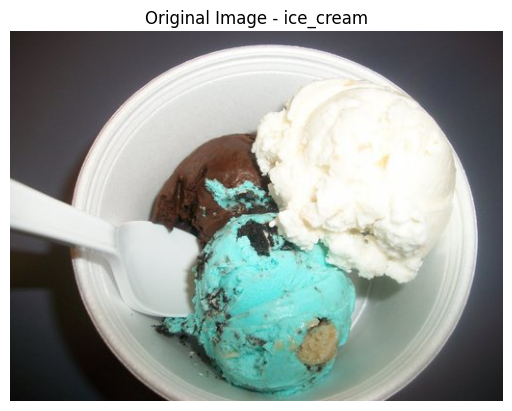

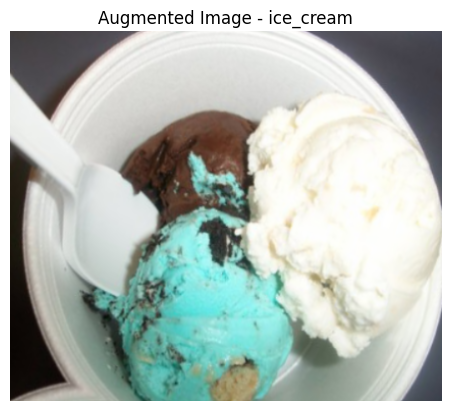

In [ ]:
#test data_augmentation layer - Visualization

# view a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

target_class = random.choice(train_dataset.class_names)
target_dir = os.path.join(train_dir, target_class)
print(target_class, target_dir)

random_image = random.choice(os.listdir(target_dir))
random_image_path = os.path.join(target_dir, random_image)
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.axis(False)
plt.title(f"Original Image - {target_class}")

#lets plot augmented image
plt.figure()
aug_img = data_augmentation(img)/255.
plt.imshow(aug_img)
plt.axis(False)
plt.title(f"Augmented Image - {target_class}")
plt.show()


In [ ]:
## model_1: Use feature extraction transfer learning on 1% of the training data with data augmentation.

# Define input shape
input_shape=IMAGE_SIZE+(3,)

# base model layer
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# input layer
inputs = tf.keras.layers.Input(shape=(input_shape), name='input_layer')

# augmentation layer
x = data_augmentation(inputs)

# passing inputs through basemodel
x = base_model(x, training=False)

# global average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#outputs
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

# combining inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

#compiling model
model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# define callback
tensorboard_callback = create_tensorboard_callback('transfer_learning', experiment_name='1_percent_aug_data')

# fitting the model
history_1 = model_1.fit(train_dataset,
                        epochs=5,
                        steps_per_epoch=len(train_dataset),
                        validation_data=test_dataset,
                        validation_steps=int(0.25*len(test_dataset)),
                        callbacks=[tensorboard_callback])

Saving TensorBoard log files to: transfer_learning/1_percent_aug_data/20230628-032527
Epoch 1/5
3/3 [==============================] - 16s 4s/step - loss: 2.3638 - accuracy: 0.1571 - val_loss: 2.2897 - val_accuracy: 0.1727
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1268 - accuracy: 0.2857 - val_loss: 2.1492 - val_accuracy: 0.2434
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.8962 - accuracy: 0.3714 - val_loss: 2.0149 - val_accuracy: 0.3520
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.6850 - accuracy: 0.5286 - val_loss: 1.9107 - val_accuracy: 0.4260
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.5394 - accuracy: 0.6571 - val_loss: 1.7837 - val_accuracy: 0.5230


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, None, 3)           0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
____________________________________________

In [ ]:
result_1_percent_data_aug_fe = model_1.evaluate(test_dataset)

79/79 [==============================] - 7s 83ms/step - loss: 1.7858 - accuracy: 0.4944


In [ ]:
result_1_percent_data_aug_fe

[1.785828709602356, 0.4943999946117401]

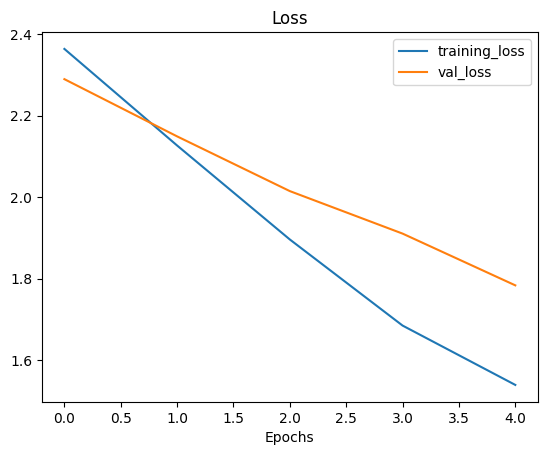

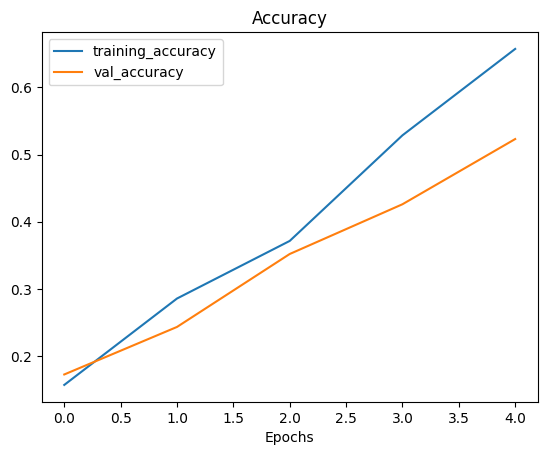

In [ ]:
plot_loss_curves(history_1)

## model_2: Use feature extraction transfer learning on 10% of the training data with data augmentation

In [ ]:
# Download data - already downloaded
! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data('10_food_classes_10_percent.zip')

--2023-06-28 03:26:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 142.251.175.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  21.5MB/s    in 8.8s    

2023-06-28 03:26:23 (18.3 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# directories
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [ ]:
# Set data imputs

import tensorflow as tf
IMAGE_SIZE =(224,224)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                     label_mode='categorical',
                                                                     batch_size=32,
                                                                     image_size=IMAGE_SIZE)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                     label_mode='categorical',
                                                                     batch_size=32,
                                                                     image_size=IMAGE_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# augmnetation layer
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
            preprocessing.RandomFlip('horizontal'),
            preprocessing.RandomRotation(0.2),
            preprocessing.RandomZoom(0.2),
            preprocessing.RandomHeight(0.2),
            preprocessing.RandomWidth(0.2)
], name='data_augmentation')

In [ ]:
## model_2: Use feature extraction transfer learning on 10% of the training data with data augmentation

# define input shape
input_shape=IMAGE_SIZE+(3,)

# define input layer
inputs = tf.keras.layers.Input(shape=(input_shape), name='input_layer')

# base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# augmentation layer
x = data_augmentation(inputs)

# passing inputs through base model
x = base_model(x, training=False) #so that batchnorm statistics don't get updated

# compress the output from basemodel to a feature vector
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)

# output layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# create model
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])



In [ ]:
# creating model checkpoint - intermediately saves model or weights so that wecan resume training where we left

#filepath
checkpoint_path = 'ten_percent-model_checkpoint_weights/checkpoint.ckpt'

# lets save weights only
model_checkpoint= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     save_best_only=False,
                                                     save_freq='epoch', #saves every epoch
                                                     verbose=1)


In [ ]:
#define thecallback
tensorboard_callback = create_tensorboard_callback('transfer_learning', experiment_name='10_percent_aug_data_fe')

initial_epochs=5

# fit themodel
history_2 = model_2.fit(train_dataset,
                        epochs=initial_epochs,
                        steps_per_epoch=len(train_dataset),
                        validation_data=test_dataset,
                        validation_steps=int(0.25 * len(test_dataset)),
                        callbacks=[model_checkpoint, tensorboard_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_aug_data_fe/20230628-032628
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0014 - accuracy: 0.3360
Epoch 1: saving model to ten_percent-model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 24s 692ms/step - loss: 2.0014 - accuracy: 0.3360 - val_loss: 1.4225 - val_accuracy: 0.6776
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3131 - accuracy: 0.7093
Epoch 2: saving model to ten_percent-model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 14s 568ms/step - loss: 1.3131 - accuracy: 0.7093 - val_loss: 0.9948 - val_accuracy: 0.7812
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0275 - accuracy: 0.7613
Epoch 3: saving model to ten_percent-model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 13s 542ms/step - loss: 1.0275 - accuracy: 0.7613 - val_loss: 0.7972 - val_accuracy: 0.8076
E

In [ ]:
# What were model_0 results, without data augmnetation
model_0.evaluate(test_dataset)

79/79 [==============================] - 6s 67ms/step - loss: 0.5577 - accuracy: 0.8640


[0.5576698780059814, 0.8640000224113464]

In [ ]:
results_10_percent_data_aug_fe = model_2.evaluate(test_dataset)
results_10_percent_data_aug_fe

79/79 [==============================] - 7s 82ms/step - loss: 0.6151 - accuracy: 0.8408


[0.6151259541511536, 0.8407999873161316]

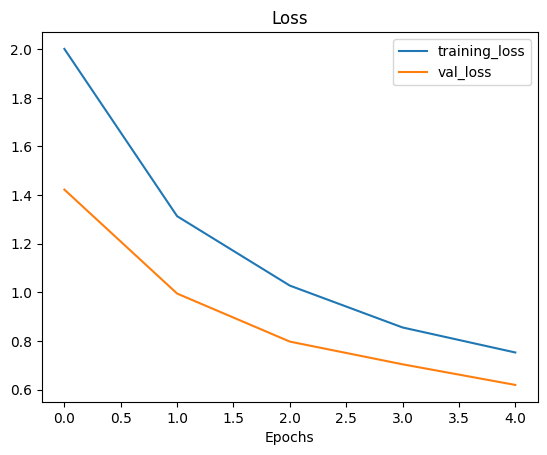

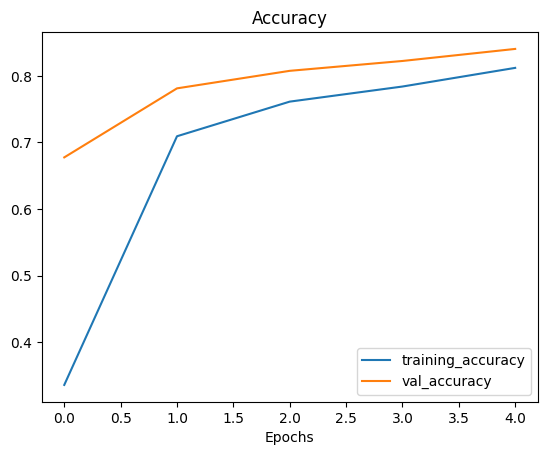

In [ ]:
plot_loss_curves(history_2)

In [ ]:
print(model_2.trainable_variables)

[<tf.Variable 'output_layer/kernel:0' shape=(1280, 10) dtype=float32, numpy=
array([[ 6.9337428e-02, -6.8167485e-02,  2.4261516e-02, ...,
        -5.7822190e-02,  8.9142490e-03,  2.3234112e-02],
       [ 2.0325663e-02, -6.1221700e-02, -3.3435814e-02, ...,
         5.0360039e-02,  5.1170303e-03,  6.8766266e-02],
       [-5.5131733e-02,  6.3853361e-02, -4.8521962e-02, ...,
        -7.6860838e-02,  6.2227504e-05, -3.7089448e-02],
       ...,
       [-7.1992613e-02, -2.8919065e-02, -4.6925794e-02, ...,
         3.1100551e-02,  6.4425496e-04,  9.6639372e-02],
       [-2.2143470e-02, -4.6662536e-02,  1.2976618e-02, ...,
        -6.6947252e-02,  5.4915462e-02,  3.4388889e-02],
       [ 2.7323997e-02, -7.5041428e-02,  8.4251367e-02, ...,
        -6.9811679e-03,  1.1410994e-02,  7.4635908e-02]], dtype=float32)>, <tf.Variable 'output_layer/bias:0' shape=(10,) dtype=float32, numpy=
array([ 0.01068772, -0.00492292,  0.00129137, -0.01215013,  0.00598233,
        0.0116602 ,  0.01536274, -0.00074084

In [ ]:
print(len(model_2.trainable_variables))

2


In [ ]:
print(len(model_2.layers[2].layers[1].trainable_variables)) # trainable variables an attribute of model or layer(not layers list)

0


In [ ]:
print(len(base_model.trainable_variables))

0


## Load weights

In [ ]:
#load saved weights
model_2.load_weights(checkpoint_path) #load weight using the checkpoint path

In [ ]:
loaded_weights_model_results = model_2.evaluate(test_dataset)
loaded_weights_model_results

79/79 [==============================] - 6s 69ms/step - loss: 0.6151 - accuracy: 0.8408


[0.6151259541511536, 0.8407999873161316]

In [ ]:
results_10_percent_data_aug_fe == loaded_weights_model_results

True

In [ ]:
results_10_percent_data_aug_fe # loss value seems off at last few decimal position

[0.6151259541511536, 0.8407999873161316]

In [ ]:
#check to see if our model result close
import numpy as np
np.isclose(np.array(results_10_percent_data_aug_fe), np.array(loaded_weights_model_results))
#result expected [[True, True]]

array([ True,  True])

In [ ]:
print(np.array(results_10_percent_data_aug_fe) - np.array(loaded_weights_model_results))

[0. 0.]


## Fine Tuning

In [ ]:
model_2.layers

In [ ]:
# What layers are in model_2 trainable
for layer in  model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f1fff7439d0> True
<keras.engine.sequential.Sequential object at 0x7f1fff7433a0> True
<keras.engine.functional.Functional object at 0x7f1fff4cbd30> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f1fff32abc0> True
<keras.layers.core.dense.Dense object at 0x7f1fff6935e0> True


In [ ]:
# What layers are in base_model
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)


0 input_6 False
1 rescaling_8 False
2 normalization_4 False
3 rescaling_9 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# How many trainable va
model_2.layers[2].trainable_variables

[]

In [ ]:
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# to fine tune , lets start by setting the last 10 layers of our base model as trainable

# first make the base model trainable
base_model.trainable=True

# Freeze all except last 10
for layer in base_model.layers[:-10]:
    layer.trainable=False

# recompile
# when finetuning, its recommended to lower the learning rate, atleast 10x, good resource is ULMFiT paper
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [ ]:
# lets now look into the base_model layers for trainable status
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_6 False
1 rescaling_8 False
2 normalization_4 False
3 rescaling_9 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# here are model_2 trainable_variable
len(model_2.trainable_variables)

12

In [ ]:
# of the 12, the 10 comes from the basemodel
len(base_model.trainable_variables)

10

In [ ]:
## model_3: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
fine_tune_epochs = initial_epochs + 5

history_fine_tune_10_percent_data_aug = model_2.fit(train_dataset,
                                                   epochs=fine_tune_epochs,
                                                   validation_data=test_dataset,
                                                   validation_steps=int(0.25*len(test_dataset)),
                                                   initial_epoch=history_2.epoch[-1], #start training ffrom previos epoch we left
                                                   callbacks=[create_tensorboard_callback('transfer_learning',
                                                                                           experiment_name='10_percent_last10_finetune')]
                                              )

Saving TensorBoard log files to: transfer_learning/10_percent_last10_finetune/20230628-032824


Epoch 5/10
24/24 [==============================] - 25s 560ms/step - loss: 0.6165 - accuracy: 0.8427 - val_loss: 0.5181 - val_accuracy: 0.8388
Epoch 6/10
24/24 [==============================] - 10s 401ms/step - loss: 0.5084 - accuracy: 0.8560 - val_loss: 0.4915 - val_accuracy: 0.8372
Epoch 7/10
24/24 [==============================] - 11s 458ms/step - loss: 0.4136 - accuracy: 0.8813 - val_loss: 0.4426 - val_accuracy: 0.8553
Epoch 8/10
24/24 [==============================] - 10s 389ms/step - loss: 0.3824 - accuracy: 0.8800 - val_loss: 0.4442 - val_accuracy: 0.8536
Epoch 9/10
24/24 [==============================] - 11s 409ms/step - loss: 0.3639 - accuracy: 0.8920 - val_loss: 0.4232 - val_accuracy: 0.8668
Epoch 10/10
24/24 [==============================] - 10s 402ms/step - loss: 0.3001 - accuracy: 0.9240 - val_loss: 0.4402 - val_accuracy: 0.8536


In [ ]:
#evaluate fine_tuned model
results_10_percent_post_fine_tune=model_2.evaluate(test_dataset)

79/79 [==============================] - 7s 84ms/step - loss: 0.4244 - accuracy: 0.8576


In [ ]:
results_10_percent_data_aug_fe

[0.6151259541511536, 0.8407999873161316]

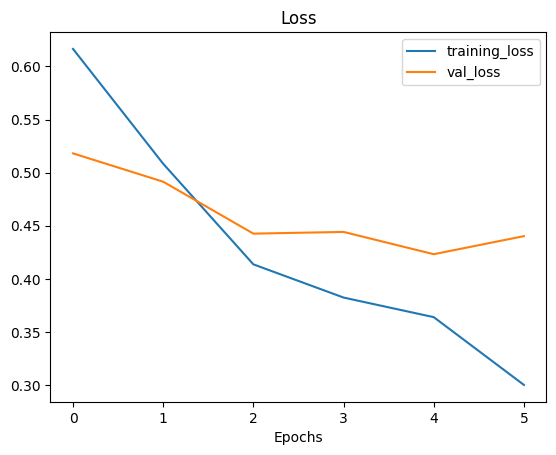

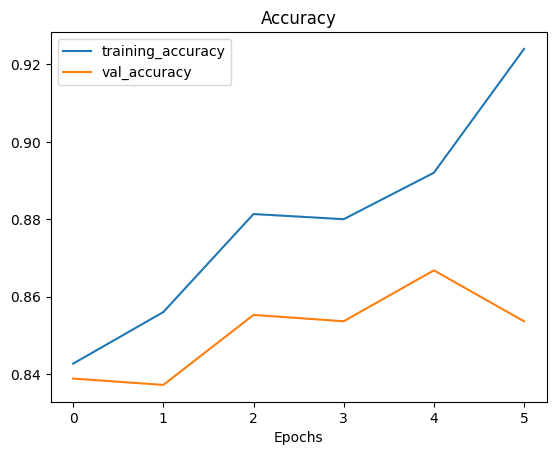

In [ ]:
# plot loass curves
plot_loss_curves(history_fine_tune_10_percent_data_aug)

In [ ]:
def compare_history(original_history, new_history, initial_epochs=5):
    """
    Compares two History objects
    """
    # Get original history measurements
    acc = original_history.history['accuracy']
    val_acc = original_history.history['val_accuracy']
    print(len(acc))

    loss = original_history.history['loss']
    val_loss = original_history.history['val_loss']

    # Get new history measurement
    total_acc = acc + new_history.history['accuracy']
    total_val_acc = val_acc + new_history.history['val_accuracy']

    total_loss = loss + new_history.history['loss']
    total_val_loss = val_loss + new_history.history['val_loss']

    print(len(total_acc))
    print(total_acc)

    # Make plots for Accuracy
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label="train_acc")
    plt.plot(total_val_acc, label="val_acc")
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), linestyle='dashed', label='Start fine tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')


    # Make plots for loss
    #plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot(total_loss, label="train_loss")
    plt.plot(total_val_loss, label="val_loss")
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), linestyle='dashed', label='Start fine tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.335999995470047, 0.7093333601951599, 0.7613333463668823, 0.7839999794960022, 0.8119999766349792, 0.8426666855812073, 0.8560000061988831, 0.8813333511352539, 0.8799999952316284, 0.8920000195503235, 0.9240000247955322]


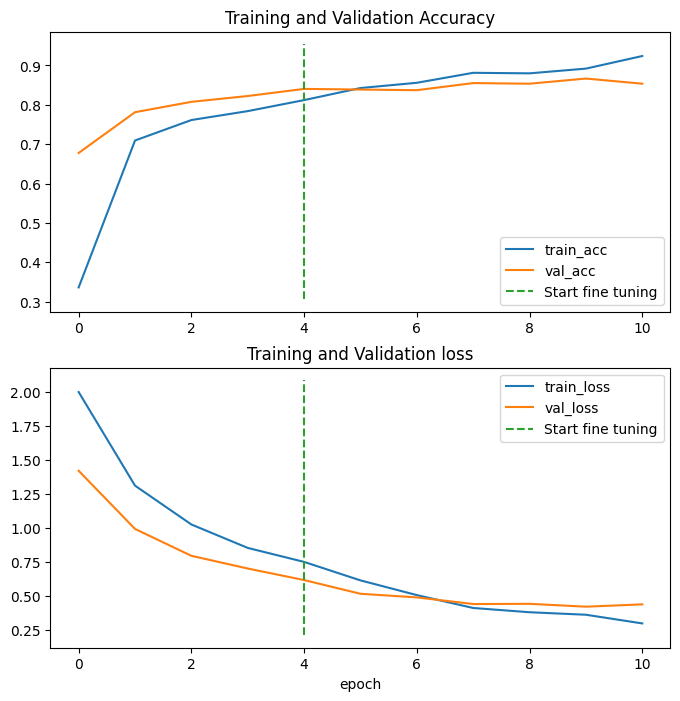

In [ ]:
compare_history(history_2, history_fine_tune_10_percent_data_aug, initial_epochs=5)

**Note: Fine tuning works best with more data**

Alright, alright, seems like the curves are heading in the right direction after fine-tuning. But remember, it should be noted that fine-tuning usually works best with larger amounts of data.

## Model 4: Fine-tuning an existing model all of the data

Enough talk about how fine-tuning a model usually works with more data, let's try it out.

We'll start by downloading the full version of our 10 food classes dataset.



In [ ]:
! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data('10_food_classes_all_data.zip')

--2023-06-28 03:29:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  23.1MB/s    in 23s     

2023-06-28 03:30:17 (21.5 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
train_dir = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

In [ ]:
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.

In [ ]:
import tensorflow as tf

IMAGE_SIZE=(224,224)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    label_mode='categorical',
                                                                    batch_size=32,
                                                                    image_size=IMAGE_SIZE)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                    label_mode='categorical',
                                                                    batch_size=32,
                                                                    image_size=IMAGE_SIZE)

In [ ]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_dataset)

79/79 [==============================] - 7s 76ms/step - loss: 0.4244 - accuracy: 0.8576


[0.42438074946403503, 0.8575999736785889]

In [ ]:
results_10_percent_post_fine_tune

[0.4243808090686798, 0.8575999736785889]

In [ ]:
## model_4: Use fine-tuning transfer learning on 100% of the training data with data augmentation

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-train

In [ ]:
# to fine tune model, we need to revert the model_2 model to feature extractor stage
# # Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
## since we have chnaged our model architecture in the previosu run by making last 10 layers of base model trainable,
## we would not be ble to further load weights on the model
## to fix that, we first revert the archtecture to original model_2 architecture, then we load weights and compile model
## then for this experiment to finetune - we need set the base model last 10 layers trainable, and recompile

# set 'False' value to the trainable attribute
base_model.trainable=False

#compile the model_2
model_2.compile(loss='catgeorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# load the weights
model_2.load_weights(checkpoint_path)

# To fine tune, set basemodel as trainable
base_model.trainable=True

for layer in base_model.layers[:-10]:
    layer.trainable = False

# recompile
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=['accuracy'])


In [ ]:
# # to fine tune model, we need to revert the model_2 model to feature extractor stage
# # # Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
# checkpoint_dir = 'ten_percent-model_checkpoint_weights'
# latest_weights = tf.train.latest_checkpoint(checkpoint_dir)

# # Note: As of TensorFlow 2.10.0+, this may error, it should work with TensorFlow 2.9.0
# # See the fix here: https://github.com/mrdbourke/tensorflow-deep-learning/issues/544
# model_2.load_weights(latest_weights)

In [ ]:
# verify the model is now reverted to previous stage
model_2.evaluate(test_dataset)

79/79 [==============================] - 9s 83ms/step - loss: 0.6151 - accuracy: 0.8408


[0.6151259541511536, 0.8407999873161316]

In [ ]:
# compae with feature extarctor result
results_10_percent_data_aug_fe

[0.6151259541511536, 0.8407999873161316]

In [ ]:
#look for trainable variable status
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [ ]:
# Check which layers are transbale
for layer_no, layer in enumerate(model_2.layers):
    print(layer_no,layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_avg_pooling_layer True
4 output_layer True


In [ ]:
for layer_no, layer in enumerate(model_2.layers[2].layers):
    print(layer_no, layer.name, layer.trainable)

0 input_6 False
1 rescaling_8 False
2 normalization_4 False
3 rescaling_9 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=['accuracy'])

In [ ]:
fine_tune_epochs = initial_epochs + 5
history_fine_tune_100_percent_data_aug= model_2.fit(train_dataset,
                                                    epochs=fine_tune_epochs,
                                                    validation_data=test_dataset,
                                                    validation_steps=int(0.25*len(test_dataset)),
                                                    initial_epoch=history_2.epoch[-1],
                                                    callbacks=[create_tensorboard_callback('transfer_learning',
                                                                                           experiment_name='full_10_class_fine_tune')])

Saving TensorBoard log files to: transfer_learning/full_10_class_fine_tune/20230628-033802
Epoch 5/10
235/235 [==============================] - 70s 255ms/step - loss: 0.6446 - accuracy: 0.7965 - val_loss: 0.3446 - val_accuracy: 0.8964
Epoch 6/10
235/235 [==============================] - 57s 240ms/step - loss: 0.5201 - accuracy: 0.8301 - val_loss: 0.3361 - val_accuracy: 0.8849
Epoch 7/10
235/235 [==============================] - 49s 208ms/step - loss: 0.4559 - accuracy: 0.8520 - val_loss: 0.3451 - val_accuracy: 0.8865
Epoch 8/10
235/235 [==============================] - 49s 206ms/step - loss: 0.4133 - accuracy: 0.8655 - val_loss: 0.2774 - val_accuracy: 0.9062
Epoch 9/10
235/235 [==============================] - 51s 213ms/step - loss: 0.3921 - accuracy: 0.8735 - val_loss: 0.2870 - val_accuracy: 0.9079
Epoch 10/10
235/235 [==============================] - 46s 195ms/step - loss: 0.3533 - accuracy: 0.8849 - val_loss: 0.2744 - val_accuracy: 0.9145


> 🔑 **Note:** Training took longer per epoch, but that makes sense because we're using 10x more training data than before.

Let's evaluate on all of the test data.

In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_dataset)
results_fine_tune_full_data

79/79 [==============================] - 7s 82ms/step - loss: 0.2598 - accuracy: 0.9148


[0.25975358486175537, 0.9147999882698059]

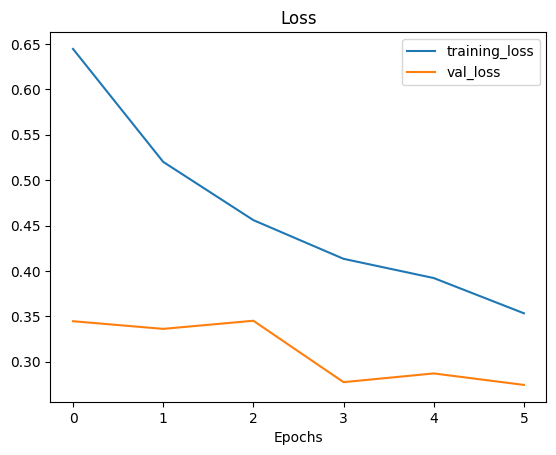

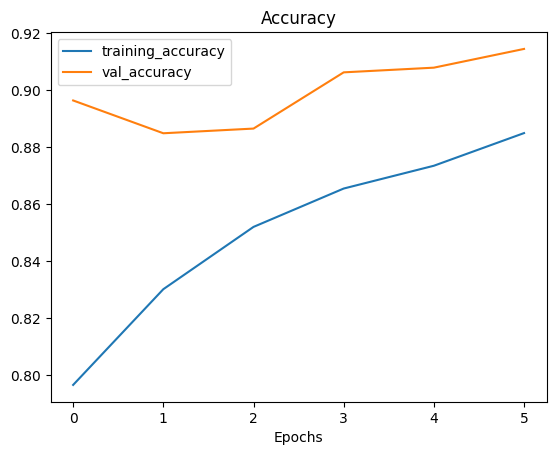

In [ ]:
plot_loss_curves(history_fine_tune_100_percent_data_aug)

5
11
[0.335999995470047, 0.7093333601951599, 0.7613333463668823, 0.7839999794960022, 0.8119999766349792, 0.7965333461761475, 0.830133318901062, 0.8519999980926514, 0.8654666543006897, 0.8734666705131531, 0.884933352470398]


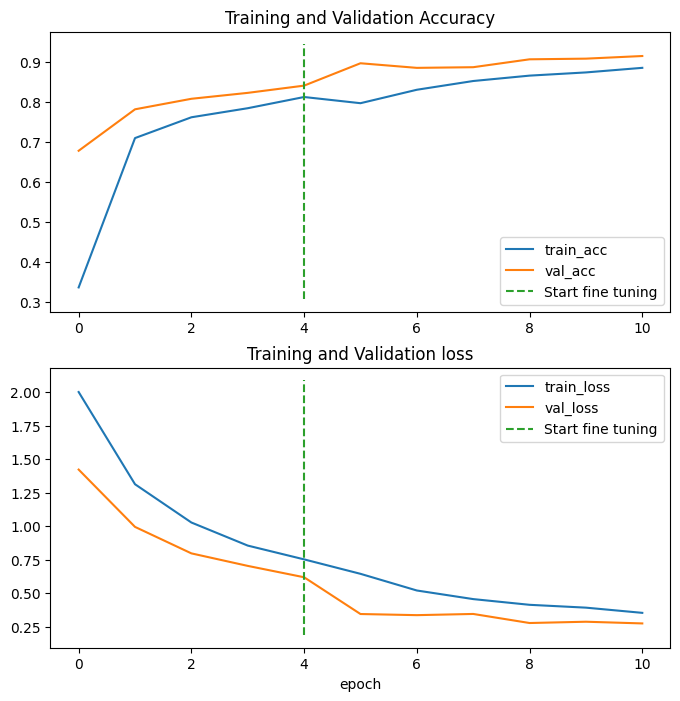

In [ ]:
# How did the fine_tuning went with more data
compare_history(history_2,
                history_fine_tune_100_percent_data_aug,
                initial_epochs=5)

Looks like that extra data helped! Those curves are looking great. And if we trained for longer, they might even keep improving.

## Viewing our experiment data on TensorBoard

Right now our experimental results are scattered all throughout our notebook. If we want to share them with someone, they'd be getting a bunch of different graphs and metrics... not a fun time.

But guess what?

Thanks to the TensorBoard callback we made with our helper function `create_tensorflow_callback()`, we've been tracking our modelling experiments the whole time.

How about we upload them to TensorBoard.dev and check them out?

We can do with the `tensorboard dev upload` command and passing it the directory where our experiments have been logged.

> 🔑 **Note:** Remember, whatever you upload to TensorBoard.dev becomes public. If there are training logs you don't want to share, don't upload them.

In [ ]:
## Viewing the experiment results on tensorboard
!tensorboard dev upload --logdir ./transfer_learning \
  --name " Transfer Learning Experiments with Food101 Classes" \
  --description 'A series of experiments with varying amount of train data' \
  --one_shot # exits the uploader

2023-06-28 03:45:51.530049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   MPQ-PQN-HFH



New experiment created. View your TensorBoard at: https://tensorboard.dev/

View the results here - https://tensorboard.dev/experiment/aeKiZmAOT2SmbYlljfwlhg/

In [ ]:
# view all experiments
!tensorboard dev list

2023-06-28 03:47:08.609613: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/aeKiZmAOT2SmbYlljfwlhg/
	Name                  Transfer Learning Experiments with Food101 Classes
	Description          A series of experiments with varying amount of train data
	Id                   aeKiZmAOT2SmbYlljfwlhg
	Created              2023-06-28 03:46:23 (47 seconds ago)
	Updated              2023-06-28 03:46:33 (37 seconds ago)
	Runs                 12
	Tags                 5
	Scalars              168
	Tensor bytes         0
	Binary object bytes  5534169
https://tensorboard.dev/experiment/N2DtNT0pRuqPhyxeK5Copw/
	Name                 EffNetb0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures
	Id                   N2DtNT0pRuqPhyxeK5Copw
	Created              2023-06-27 05:52:31 (21 hours ago)
	Updated              2023-06-27 05:52:34 (21 hours ago)
	Runs           

In [ ]:
#delete any experiment
#!tensorboard dev delete --experiment_id #provide_id_here